In [1]:
import os
import tarfile
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from functions import *

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
print(DOWNLOAD_ROOT)
HOUSING_PATH = os.path.join("datasets", "housing")
print(HOUSING_PATH)
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
print(HOUSING_URL)

## function to fetch the data from a github repository

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

https://raw.githubusercontent.com/ageron/handson-ml2/master/
datasets\housing
https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz


In [3]:
## this will fetch the data to the envirinment.
fetch_housing_data()

In [4]:
## function to load the datasets.
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")  ## here housing path = datasets\housing, and filename = "housing.csv"
    return pd.read_csv(csv_path)                          ## return the pad.read_csv file as a pandas dataframe.

In [7]:
housing = load_housing_data()
#housing.head()

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
(16512, 11)
(4128, 11)


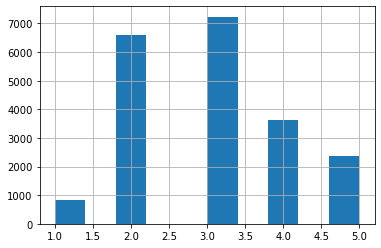

In [6]:
## Split the data to train and test set using train test split function.
#from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
# print("The training set shape is :--", train_set.shape)
# print("The training set shape is :--", test_set.shape)

## stratified splitting.
## the median_income is a very important parameter in finding the pricing.
## so we need ensure that, when we do the training, the median_income data should be representative of various ranges.
## for that we will split the data of the median income to income category and then do the stratified sampling.

housing["income_cat"] = pd.cut(housing["median_income"],
                                  bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                                  labels = [1,2,3,4,5])
#housing.head()
housing["income_cat"].hist()

## do the stratified sampling using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
splits = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
print(splits)
for train_index, test_index in splits.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print(strat_train_set.shape)
print(strat_test_set.shape)

In [10]:
print(strat_train_set.shape)
print(strat_test_set.shape)

(16512, 11)
(4128, 11)


### Data Pipeline

In [11]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [14]:
print(housing.shape)
print(housing_labels.shape)

(16512, 10)
(16512,)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## defining the pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [20]:
housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'income_cat']

In [21]:
cat_attribs = ["ocean_proximity"]
cat_attribs

['ocean_proximity']

In [22]:
from sklearn.compose import ColumnTransformer

housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [29]:
housing_prepared = full_pipeline.fit_transform(housing)
print(type(housing_prepared))
print(housing_prepared.shape)
print(housing_prepared.ndim)
print(housing_prepared.size)
print(housing_prepared.dtype)

<class 'numpy.ndarray'>
(16512, 14)
2
231168
float64


### Model Training

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

forest_reg = RandomForestRegressor(n_estimators=5, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE ==> ", forest_rmse)

RMSE ==>  25561.078215525944


### Model Tuning

In [32]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
    
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52482.60903894 55788.47017606 56301.61981799 55773.63756263
 56061.40029919]
Mean: 55281.54737896094
Standard deviation: 1412.9329538500028


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)

print(grid_search.best_estimator_)

{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65366.66703580078 {'max_features': 2, 'n_estimators': 3}
56858.68648818557 {'max_features': 2, 'n_estimators': 10}
53728.51250871097 {'max_features': 2, 'n_estimators': 30}
62502.3123324232 {'max_features': 4, 'n_estimators': 3}
54264.450707578435 {'max_features': 4, 'n_estimators': 10}
52181.399883553015 {'max_features': 4, 'n_estimators': 30}
59858.8772743321 {'max_features': 6, 'n_estimators': 3}
53493.70578220264 {'max_features': 6, 'n_estimators': 10}
51665.391094883606 {'max_features': 6, 'n_estimators': 30}
59233.69330573073 {'max_features': 8, 'n_estimators': 3}
52997.00491751953 {'max_features': 8, 'n_estimators': 10}
51109.833236342696 {'max_features': 8, 'n_estimators': 30}
62734.8537194592 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55244.37690148358 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60824.09594667789 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53772.33825766095 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

### Evaluate the Model

In [36]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [37]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [39]:
print("RMSE on Test ==> ",final_rmse)

RMSE on Test ==>  48474.605007937585
